In [2]:
import os, pickle, sys
from absl import logging
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from arguments import get_args
logging.get_absl_handler().python_handler.stream = sys.stdout

Before using the package, the user must specify the arguments in the config.py file. All available parameters are defined in `arguments.py`.\
The method `get_path_dict` accepts one of the four strings 'train', 'eval', 'optimize', or 'test'. The strings point to different dictionaries that are used for composing the dataset paths. We need to use dataset paths because the dataset is too large to be loaded into RAM.\
The method `get_config` contains the ids that specify the strings for data loading, the paths for saving results from training, validation, hyperparameter optimization, and testing.

Set up the configuration with `get_args` and `get_config`, and call `get_path_dict` to obtain all paths that point to data used for training. Next, instantiate a trainer instance.

In [3]:
from config import get_config, get_path_dict
from train import Trainer

args = get_args()
args = get_config(args)
args.n_episodes = 10
args.load_every = 200
args.len_cross_val = 200
args.len_dataset = 10
args.batch_size = 4
args.device = pt.device('cuda' if pt.cuda.is_available() else 'cpu')
path_dict = get_path_dict(f'{args.train_dataset_id}')
if not os.path.exists('results'):
    os.makedirs('results')
trainer = Trainer(args, path_dict)

For training, call `trainer.train()`. After training, the network parameters and the losses are saved at `results`.

During training, we load a training set of length `args.len_dataset` into RAM from the full dataset. Since datapoints are only included in the locally loaded datasets if the network does not correctly identify the animal position, data loading can take quite long, especially when the network is already very perfomant (for details, cf. methods).\
During training, the loss is shown at regular intervals, and after each round of cross validation, we additionally show the ratio between the correctly identified positions and all datapoints in the cross validation set.

The cross validation set at has to be pre-defined by the user. The `data` folder contains a dictionary specifying all data file paths and frame indices.

In [4]:
trainer.train()

INFO:absl:building dataset
INFO:absl:iteration: 0 --- loss: 0.7342348694801331
INFO:absl:cross validate
INFO:absl:epoch: 0 --- loss: 0.7342348694801331 --- cross val ratio: 0.0
INFO:absl:finis


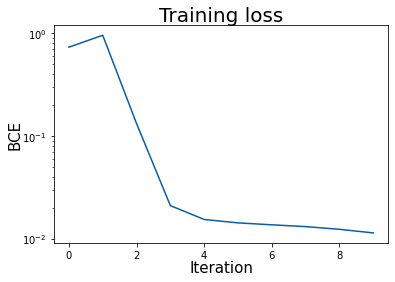

In [5]:
losses = pickle.load(open('results/train_loss', 'rb'))
plt.plot(losses, c='#065da4')
plt.yscale('log')
plt.xlabel('Iteration', labelpad=0, size=15)
plt.ylabel('BCE', labelpad=0, size=15)
plt.title('Training loss', pad=0, size=20);

Next, we run a baseline test with trained model on the evaluation set by calling `eval_baseline()`.

In [6]:
from evaluate import eval_baseline
from model import Model

args = get_args()
args = get_config(args)
args.min_len_block = 1
print(args.train_dataset_id)
test_path_dict = get_path_dict(f'{args.train_dataset_id}')
state_dict_path = f'{args.state_dict_path}'
model = Model(args, core_type = args.core_type).to(args.device)
model.load_state_dict(pt.load(state_dict_path, map_location=f'{args.device}'), strict=False)
eval_baseline(args, test_path_dict, model)

train


  0%|                                                     | 0/9 [00:00<?, ?it/s]/opt/homebrew/lib/python3.9/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 23.76it/s]


For further optimization and rapid testing, we save 6 pieces of data during baseline testing:
1. The list of indices that was included (this might not be the full list of indices in the dataset, since we exclude low-quality ground truth data before testing)
2. The difference between the estimated x coordinate and the ground truth
3. The difference between the estimated y coordinate and the ground truth
4. A list of all x coordinates that the network found (this can be more than one, depending on the number of peaks in the output heatmap)
5. A list of all y coordinates that the network found (this can be more than one, depending on the number of peaks in the output heatmap)
6. The values at the peaks of the Gaussians around the candidate coordinates

Below, we plot radial distance to ground truth over the frame indices.

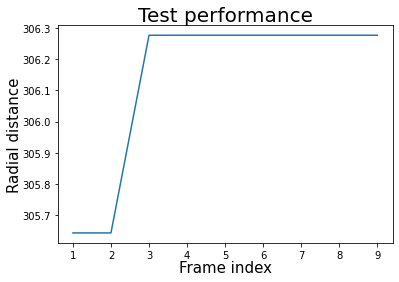

In [7]:
test_result_path = 'results/result'
test_baseline_results = pickle.load(open(test_result_path, 'rb'))
idx_list, x_diff, y_diff, candidate_x_coordinate_list, candidate_y_coordinate_list, peak_list = test_baseline_results
radial_distance_to_ground_truth = np.sqrt(np.power(x_diff, 2) + np.power(y_diff, 2))
plt.plot(idx_list, radial_distance_to_ground_truth)
plt.xlabel('Frame index', labelpad=0, size=15)
plt.ylabel('Radial distance', labelpad=0, size=15)
plt.title('Test performance', pad=0, size=20);

The information saved during baseline testing can be used for model-free hyperparameter optimization, leading to a speedup by a factor of 30, enabling rapid testing of a large number of hyperparameters. It is assumed that the same path dictionaries is used for baseline testing and hyperparameter optimization.\
A separate file for each set of hyperparameters is saved in `results`. Each file contains a dictionary of 1. the difference between the estimated x coordinate and the ground truth, 2. the difference between the estimated y coordinate and the ground truth, indexed by file paths contained in the evalutation set.\
The user can specify the ranges from which the hyperparameters are being sampled (defined in `config.py`). The user can also control the number of pairs tested with `args.n_epochs_opt_hyperp`. To execute the search, call `opt_hyperp_model_free()`.

In [8]:
from search_hp import search_hp_model_free
args.n_epochs_opt_hyperp = 3
search_hp_model_free(args, test_path_dict, args.n_epochs_opt_hyperp)

INFO:absl:(3.359818286283781e-05, 110.0)
100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 1815.98it/s]
INFO:absl:(0.0006951927961775605, 80.0)
100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 674.06it/s]
INFO:absl:(0.000379269019073225, 50.0)
100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 717.02it/s]


In [13]:
def get_histogram(result_dict, max_pixel_cutoff = args.h):
    ''' 
    score histogram for hyperp optimization
    '''
    hist_dict = {}
    for key, value in result_dict.items():
        if not key == 'h':
            hist = []
            x_diff, y_diff = value
            distance = np.sqrt(np.power(x_diff, 2) + np.power(y_diff, 2))
            for pixel_cutoff in range(max_pixel_cutoff):
                hist.append(len(distance[distance > pixel_cutoff]))
            hist_dict[key] = hist
    return hist_dict

result_dict = pickle.load(open(f"results/search_hp_0", "rb"))
hist_dict = get_histogram(result_dict)

Text(0.5, 1.0, 'Number of frames over error tolerance')

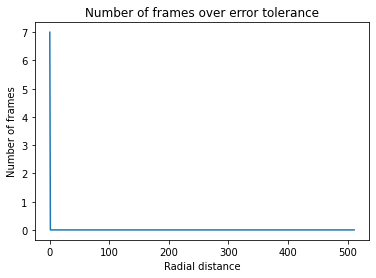

In [14]:
plt.plot(hist_dict[test_result_path])
plt.xlabel('Radial distance')
plt.ylabel('Number of frames');
plt.title('Number of frames over error tolerance')

After picking the best performing hyperparameters, save them in `results/hp`.\
Lastly, we test the optimized algorithm on unseen test data by calling `test()`. After testing, the x and y coordinates are saved in `results`.

In [15]:
from data_utils import get_ground_truth
from file_sys_utils import file_read
from test import test, track
from general_utils import get_hp
args.hp = 'results/hp'
# correlation_scale, hard_boundary = get_hp(args.hp)
correlation_scale, hard_boundary = 0.00020691380811147902, 120.0
print((f'correlation scale = {correlation_scale}, boundary = {hard_boundary}'))
test(args, test_path_dict, model, correlation_scale, hard_boundary)

correlation scale = 0.00020691380811147902, boundary = 120.0


  0%|                                                    | 0/10 [00:00<?, ?it/s]/opt/homebrew/lib/python3.9/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 23.02it/s]


Below we show results from testing on the image frames from the test set. The red dot is the estimated position.

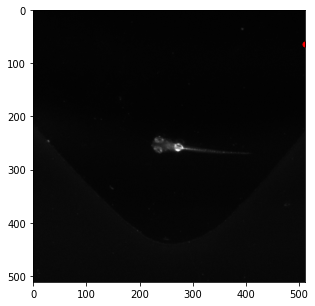

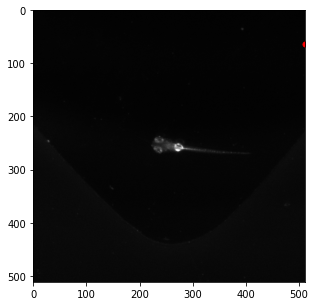

In [16]:
test_results = pickle.load(open('results/result_hp', 'rb'))
filename, handle, indices, ground_truth_x_fov, ground_truth_y_fov = get_ground_truth(test_path_dict, 0)
x_coordinate_list, y_coordinate_list = test_results
x = file_read(handle, 0)

for i in range(0, 10, 5):
    x = file_read(handle, i)
    plt.figure(figsize=(5, 5))
    plt.imshow(x, cmap='gray')
    plt.scatter(x_coordinate_list[i], y_coordinate_list[i], c='r', s=25)

You might see a discrepancy between the test performance during hyperparameter optimization and the final performance of the network. This is because is the `search_hp()` method assumes a correct baseline performance at the beginning of each dataset in order to find a pair of hyperparameters that accounts for errors that occur when the network is already performant rather than preventing an underperformant network from performing even worse.

Live tracking can be simulated using `track()`. Here, we save the coordinates, the calculated offsets called `anchor_list` (upper left corner of the FOV), and radial distance to ground truth.

In [17]:
track(args, test_path_dict, model, correlation_scale, hard_boundary)

 10%|████▍                                       | 1/10 [00:00<00:00, 10.16it/s]
